In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import time
import math
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

def de_boor(knots, t, CP, p): #Accepts original knots, parameter t to evaluate at, Control points and power.
  k = 0
  s = p+1,CP.shape[1],CP.shape[2]

  E = np.zeros(s)
  while t > knots[p+k+1]:
    k = k+1
  for i in range(p+1):
    E[i] = CP[i+k]
  for j in range(1,p+1):
    for i in range(0,p-j+1):
      E[i] = ((knots[p+1+i+k]-t)*E[i]/(knots[p+1+i+k]-knots[i+k+j])) + ((t-knots[i+k+j])*E[i+1]/(knots[p+1+i+k]-knots[i+k+j]))
  return E[0] #returns the B-splines evaluated at t.

def first_derivative(P, knots): #Accepts the original interpolation points and original set of knots.
  Q=[] #1st derivative control points

  for i in range(len(P)-1):
    Q.append((3/(knots[i+4]-knots[i+1]))*(P[i+1]-P[i]))

  knots = knots[1:-1] #New set of knots the 1st derivative is defined over.

  #C = b_spline(Q,knots,1000,True,2)

  return (Q, knots)

def second_derivative(Q, knots): #Accepts the 1st derivative control points and set of knots the 1st derivative is defined over.
  R=[] #2nd derivative control points

  for i in range(len(Q)-1):
    R.append((2/(knots[i+3]-knots[i+1]))*(Q[i+1]-Q[i]))

  knots = knots[1:-1] #New set of knots the 2nd derivative is defined over.

  #C = b_spline(R,knots,1000,True,1)
  
  return (R, knots)


def local_curvature(C, knots, t, p):

	(Q, dknots) = first_derivative(C, knots) 
	(R, ddknots) = second_derivative(Q, dknots)
	Q = np.asarray(Q)
	spline_prime = de_boor(dknots, t, Q, p-1)
	R = np.asarray(R)
	spline_dprime = de_boor(ddknots, t, R, p-2)
	curvature = ((spline_prime[0][0]*spline_dprime[1][0])-(spline_prime[1][0]*spline_dprime[0][0]))/((spline_prime[0][0]**2+spline_prime[1][0]**2)**(3))**(0.5)
	
	return curvature 

def global_curvature(C, knots, p): #Accepts control points, original knots and power.


	L = np.linspace(knots[p], knots[len(knots)-(p-1)], 1000)

	h = 1.0/(len(L)-1)

	S1 = 0
	S2 = 0
	
	for i,j in enumerate(L):
		if i%2 == 1:
			curvature = local_curvature(C, knots, j, 3)
			S1 +=  curvature**2
		else:
			curvature = local_curvature(C, knots, j, 3)
			S2 += curvature**2  

	integration = (h/3)*(4*S1 + 2*S2)
	
	return integration

def construct(t,knots,p):  
  N = np.zeros(len(knots)-1)
  lenN = len(N)
  for i,k in enumerate(knots[1:]):
    if t<k and t>= knots[i]:
      N[i] = 1
    else:
      N[i] = 0
  for power in range(1,p+1):

    for index in range(0,lenN-power):
      num = (t-knots[index])
      den = (knots[index+power]-knots[index])
      if den == 0:
        a = 0
      else:
        a = num/ den
     
      num = (knots[index+power+1]-t)
      den = (knots[index+power+1]-knots[index+1])
      if den == 0:
        b = 0
      else:
        b = num/den
      N[index] = N[index]*a + N[index+1]*b

  return N


#Constructs the interpolation matrix for B-splines with natural conditions.
def construct_A(P, knots): #accepts Points to interpolate and the knots.
	A=[[]]
#tri-diagonal part of the matrix.
	for i,k in enumerate(knots[3:-3]):
	  a = construct(k,knots,3)
	  if k==1:
	    a = np.zeros(len(knots)-1)
	    a[len(P)+1]=1
	  if i==0:
	    A=np.concatenate((A,[a]),1) 
	  else:
	    A=np.concatenate((A,[a]),0) 
	A = A[:,0:len(P)+2]

#First row is C''(u_0) = 0
	a=np.zeros(len(P)+2)
	a[0]=knots[5]
	a[1]=-knots[4]-knots[5]
	a[2]=knots[4]
	A=np.concatenate(([a],A),0) 

#Last row is C''(u_n) = 0
	a=np.zeros(len(P)+2)
	a[-3]=1-knots[len(P)+1]
	a[-2]=knots[len(P)+1]+knots[len(P)]-2
	a[-1]=1-knots[len(P)]
	A=np.concatenate((A,[a]),0) 

	return A

#Solve for control points via A-1@P
def solve(P, knots): #accepts Points to interpolate and the knots.
	
#x-coordinates of the points	
	Px = (list(map(lambda x: x[0][0],P)))
	Px=np.concatenate(([0],np.array(Px)),0)
	Px=np.concatenate((np.array(Px),[0]),0)

#y-coordinates of the points
	Py = (list(map(lambda x: x[1][0],P)))
	Py=np.concatenate(([0],np.array(Py)),0)
	Py=np.concatenate((np.array(Py),[0]),0)

#x-coordinates and y-coordinates of the control points.
	A = construct_A(P, knots)
	Cx = np.dot(np.linalg.inv(A),np.expand_dims(Px,1))
	Cy = np.dot(np.linalg.inv(A),np.expand_dims(Py,1))

#concatenate x-coordinates and y-coordinates.
	D=np.concatenate((Cx,Cy),1)
	D=np.expand_dims(D,2)

	return D

def trace(knots, mesh, p, clamp):
  num_knots = len(knots)
  num_basis = num_knots - p - 1
  X = []
  Y = np.zeros((num_basis , mesh))
  first = 0
  last = 0
  if clamp==False:
    array = np.array([])
    
    for index,i in enumerate(np.linspace(0,0.999,mesh)):
      
      if i>=knots[p] and i<=knots[num_knots-p-1]:
        if X==[]:
          first = index
        N = construct(i,knots,p)
        X.append(i)
        array = np.append(array,index)
        for j,k in enumerate(N[0:num_basis]):
          Y[j,index] = k
        last = index
    
    ret = (X,Y[:,first:last+1])
  else:
    for index,i in enumerate(np.linspace(0,0.999,mesh)):  
      N = construct(i,knots,p)
      X.append(i)
      for j,k in enumerate(N[0:num_basis]):
        Y[j,index] = k
    ret = (X,Y)

  return ret

def b_spline(P,knots,mesh,clamp,p):
  T = trace(knots,mesh,p,clamp)
  C = 0 
  for i,j in enumerate(T[1]):
    C += P[i] * j  
  return C

def centripetal(P):
  shifted = np.roll(P,1,axis=0)
  shifted[0] = np.array([[0],[0]])
  sides = P - shifted
  sides = sides[1:]
  d = np.zeros(len(sides))
  for j,i in enumerate(sides):
    d[j] = np.sqrt(np.sqrt(i.T@i)[0][0])
  L = sum(d)
  knots = np.zeros(len(P)+6)
  knots[-4:] = np.ones(4)
  s=0
  for i in range(4,4+len(P)-2):
    s+= d[i-4]
    knots[i] = s/L
  return knots

def uniform(P):
  knots = np.zeros(len(P)+6)
  knots[-4:] = np.ones(4)
  knots[3:-3]=np.linspace(0,1,len(P))
  return knots

def chordal(P):
  shifted = np.roll(P,1,axis=0)
  shifted[0] = np.array([[0],[0]])
  sides = P - shifted
  sides = sides[1:]
  d = np.zeros(len(sides))
  for j,i in enumerate(sides):
    d[j] = (np.sqrt(i.T@i)[0][0])
  L = sum(d)
  knots = np.zeros(len(P)+6)
  knots[-4:] = np.ones(4)
  s=0
  for i in range(4,4+len(P)-2):
    s+= d[i-4]
    knots[i] = s/L
  return knots

def plot_b_spline(Ct,P,C):
  plt.scatter(Ct[0],Ct[1])
  plt.scatter(list(map(lambda x: x[0][0],P)), list(map(lambda x: x[1][0],P)), c='k')
  plt.plot(list(map(lambda x: x[0][0],C)), list(map(lambda x: x[1][0],C)), c='r')
  plt.xlim([-5, 15])
  plt.ylim([-5, 15])


def plot_b_spline2(Ct,P,C,x_axis,y_axis):
  plt.scatter(Ct[0],Ct[1])
  plt.scatter(list(map(lambda x: x[0][0],P)), list(map(lambda x: x[1][0],P)), c='k')
  plt.plot(list(map(lambda x: x[0][0],P)), list(map(lambda x: x[1][0],P)), c='k')
  plt.plot(list(map(lambda x: x[0][0],C)), list(map(lambda x: x[1][0],C)), c='r')
  plt.xlim(x_axis)
  plt.ylim(y_axis)

def f_diff(P, knots, h):
  knots_h = np.copy(knots)
  C = solve(P, knots)
  curve = global_curvature(C, knots,3,1000)
  prime = np.zeros(len(knots))
  count = 0
  for i in range(4 , 4+sum(np.logical_and(knots>0,knots<1))):
    count+=1
    knots_h = np.copy(knots)
    knots_h[i] = knots_h[i] + h
    #delete
    #print("knots_h-b4",knots_h)
    #print("knots_h-aft",knots_h)
    C_h = solve(P, knots_h)
    curve1 = global_curvature(C_h, knots_h,3,1000)
    curve_prime1 = (curve1-curve)/h
    prime[i] = curve_prime1
    print("grad-"+str(count)+" : ",curve_prime1)
  print("curvature : ",curve)

  return prime, curve

def truncate(number, digits) -> float:
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper

def plot_b_spline_multiple(ax,Ct,P,C,x_axis,y_axis):
  ax.scatter(Ct[0],Ct[1])
  ax.scatter(list(map(lambda x: x[0][0],P)), list(map(lambda x: x[1][0],P)), c='k')
  ax.plot(list(map(lambda x: x[0][0],P)), list(map(lambda x: x[1][0],P)), c='k')
  ax.plot(list(map(lambda x: x[0][0],C)), list(map(lambda x: x[1][0],C)), c='r')
  ax.set_xlim(x_axis)
  ax.set_ylim(y_axis)

In [ ]:
def global_curvature(C, knots, p, num_pts): #Accepts control points, original knots and power.
 L = np.linspace(knots[p], knots[len(knots)-(p-1)], num_pts)
 h = 1.0/(len(L)-1)
 S1 = 0
 S2 = 0
 #s1=0
 #s2=0
 (Q, knots2) = first_derivative(C, knots) 
 Q = np.asarray(Q)
 for i,j in enumerate(L):
  if i%2 == 1:
   curvature = local_curvature(C, knots, j, 3)
   
   evl = de_boor(knots2,j,Q,2)
   S1 +=  (curvature**2) *LA.norm(evl) 
   #s1+=LA.norm(evl)
  else:
   curvature = local_curvature(C, knots, j, 3)
   
   evl = de_boor(knots2,j,Q,2)
   S2 += (curvature**2) *LA.norm(evl)
   #s2+=LA.norm(evl)

 integration = (h/3)*(4*S1 + 2*S2)
 #arc = (h/3)*(4*s1 + 2*s2)
	
 return integration
 #+(lambda_var)*arc
 

In [ ]:
def arc(C, knots, p, num_pts): #Accepts control points, original knots and power.
 L = np.linspace(knots[p], knots[len(knots)-(p-1)], num_pts)
 h = 1.0/(len(L)-1)
 s1=0
 s2=0
 (Q, knots2) = first_derivative(C, knots) 
 Q = np.asarray(Q)
 for i,j in enumerate(L):
  if i%2 == 1:
   evl = de_boor(knots2,j,Q,2)
   s1+=LA.norm(evl)
  else:
   evl = de_boor(knots2,j,Q,2) 
   s2+=LA.norm(evl)

 arc = (h/3)*(4*s1 + 2*s2)
	
 return arc

In [ ]:
def f_diff(P, knots, h):
  knots_h = np.copy(knots)
  C = solve(P, knots)
  curve = arc(C, knots,3,1000)
  prime = np.zeros(len(knots))
  count = 0
  for i in range(4 , 4+sum(np.logical_and(knots>0,knots<1))):
    count+=1
    knots_h = np.copy(knots)
    knots_h[i] = knots_h[i] + h
    #delete
    #print("knots_h-b4",knots_h)
    #print("knots_h-aft",knots_h)
    C_h = solve(P, knots_h)
    curve1 = arc(C_h, knots_h,3,1000)
    curve_prime1 = (curve1-curve)/h
    prime[i] = curve_prime1
    print("grad-"+str(count)+" : ",curve_prime1)
  print("curvature : ",curve)

  return prime, curve

Pytorch

In [ ]:
import torch
from torch.autograd import Variable

final and all doubels

In [ ]:
import torch
from torch.autograd import Variable

def construct(t,knots,p):  
  N = torch.zeros(knots.shape[0],knots.shape[1]-1,dtype=torch.double).to(device)
  vec = torch.zeros(len(knots),dtype=torch.double).to(device)
  vec2 = torch.ones(len(knots),dtype=torch.double).to(device)

  lenN = N.shape[1] - 1
  for i in range(knots[0,1:].shape[0]):
    v = torch.where(torch.logical_and(t<knots[:,i+1],t>= knots[:,i]),vec2,vec)
    N[:,i] = v
    # print(N[:,i])

  for power in range(1,p+1):
    for index in range(0,lenN-power):
      num = (t-knots[:,index])
      den = (knots[:,index+power]-knots[:,index])
      a = torch.zeros(knots.shape[0],dtype=torch.double).to(device)
      
      ind = torch.nonzero(den, as_tuple=True)
      a[ind] = num[ind]/den[ind]

     
      num = (knots[:,index+power+1]-t)
      den = (knots[:,index+power+1]-knots[:,index+1])
      # if den == 0:
      #   b = torch.tensor([0])
      # else:
      #   b = torch.tensor([num/ den])
      b = torch.zeros(knots.shape[0],dtype=torch.double).to(device)
      
      ind = torch.nonzero(den, as_tuple=True)
      b[ind] = num[ind]/den[ind]
      
      N[:,index] = N[:,index].clone()*a.clone() + N[:,index+1].clone()*b.clone()
  
  
  return N

def construct_A(P, knots): #accepts Points to interpolate and the knots.

  for i in range(knots[0,3:-3].shape[0]):
 
    a = construct(knots[:,i+3],knots,3)
    if knots[0,i+3]==1:
      a = torch.zeros(knots.shape[0], knots.shape[1]-1).to(device)
      a[:,len(P[0])+1]=1
      

    if i==0:
      A = torch.unsqueeze(a,1)
      #A=torch.cat((A,torch.unsqueeze(a,0)),1) 
    else:
      A = torch.cat((A,torch.unsqueeze(a,1)),1) 

      #A=torch.cat((A,torch.unsqueeze(a,0)),0) 
  A = A[:,:,0:len(P[0])+2]

  a = torch.zeros(knots.shape[0], len(P[0])+2).to(device)

  A = torch.cat((torch.unsqueeze(a,1),A),1) 
  A = torch.cat((A,torch.unsqueeze(a,1)),1) 
  A[:,0,0] += knots[:,5]
  A[:,0,1] += -knots[:,4]-knots[:,5]
  A[:,0,2] += knots[:,4]


  # #Last row is C''(u_n) = 0

  A[:,-1,-3] += 1-knots[:,len(P[0])+1]
  A[:,-1,-2] += knots[:,len(P[0])+1] + knots[:,len(P[0])]-2
  A[:,-1,-1] += 1 - knots[:,len(P[0])]
  
  return A

def solve(P, knots):
  L = (list(map(lambda x: x[:,0],P)))
  count = 0
  for i in L:
    if count == 0:
      Px = i.unsqueeze(0)
    else:
      Px = torch.cat((Px,i.unsqueeze(0)),0)
    count+=1
  
  Px = torch.cat((torch.zeros(Px.shape[0],1,1).to(device), Px),1)
  Px = torch.cat((Px, torch.zeros(Px.shape[0],1,1).to(device)),1)

  L = (list(map(lambda x: x[:,1],P)))
  count = 0
  for i in L:
    if count == 0:
      Py = i.unsqueeze(0)
    else:
      Py = torch.cat((Py,i.unsqueeze(0)),0)
    count+=1
  Py = torch.cat((torch.zeros(Py.shape[0],1,1).to(device), Py),1)
  Py = torch.cat((Py, torch.zeros(Py.shape[0],1,1).to(device)),1)

  #Py[:,0] = Py[:,1]
  #Py[:,1] = 0

  #Py[:,-1] = Py[:,-2]
  #Py[:,-2] = 0

  A = construct_A(P, knots)
  
  inv,info = torch.linalg.inv_ex(A)
  Cx = torch.bmm(inv, Px)
  Cy = torch.bmm(inv, Py)

  D = torch.cat((Cx,Cy),2)
  D = torch.unsqueeze(D,3)

  return D
  
def de_boor(knotss, t, CP, p): #Accepts original knots, parameter t to evaluate at, Control points and power.
  k = 0
  s = CP.shape[0],p+1,CP.shape[2],CP.shape[3]
  E = torch.zeros(s,dtype=torch.double).to(device)
  vec = torch.zeros(len(knotss),dtype=torch.double).to(device)
  vec2 = torch.ones(len(knotss),dtype=torch.double).to(device)
  k = torch.zeros(len(knotss),dtype=torch.double).to(device)

  for i in range(p+1,len(knotss[0])):
    v = torch.where(t>knotss[:,i],vec2,vec)
    k += v

  
  for i in range(p+1):
    I = torch.fill(v,i).to(device)
    # print(I)
    # print(I+k)
    # print(CP[torch.arange(len(knotss)),(I+k).type(torch.LongTensor)])
    # print()
    # break
    E[torch.arange(len(knotss)),I.type(torch.LongTensor)] = CP[torch.arange(len(knotss)),(I+k).type(torch.LongTensor)]
  
  
  al = torch.arange(len(knotss))
  for j in range(1,p+1):
    for i in range(0,p-j+1):
      I = torch.fill(v,i)
      P = torch.fill(v,p)
      J = torch.fill(v,j)
      indI = I.type(torch.LongTensor)
      indPIK1 = (P+1+I+k).type(torch.LongTensor)
      indIKJ = (I+k+J).type(torch.LongTensor)
      indI1 = (I+1).type(torch.LongTensor)
      ans1 = torch.cat(((knotss[al,indPIK1 ]).unsqueeze(1),(knotss[al,indPIK1 ]).unsqueeze(1)),1).unsqueeze(2)
      ans2 = torch.cat(((knotss[al,indIKJ ]).unsqueeze(1),(knotss[al,indIKJ ]).unsqueeze(1)),1).unsqueeze(2)
      tt = torch.cat(((t).unsqueeze(1),(t).unsqueeze(1)),1).unsqueeze(2)    
      #E = E.type(torch.DoubleTensor)
      E[al,indI] = (((ans1-tt)*E[al,indI].clone()/(ans1- ans2)) 
      + ((tt-ans2)*E[al,indI1].clone()
      /(ans1-ans2)))


  return E[:,0] #returns the B-splines evaluated at t.
  # return 

def first_derivative(P, knotss): #Accepts the original interpolation points and original set of knots.
  #Q=[] #1st derivative control points
  Q = torch.zeros((len(P),len(P[0])-1,2,1),dtype=torch.double).to(device)
  for i in range(len(P[0])-1):
    ans1 = torch.cat(((knotss[:,i+4]-knotss[:,i+1]).unsqueeze(1), (knotss[:,i+4]-knotss[:,i+1]).unsqueeze(1)),1).unsqueeze(2)
    Q[:,i] = ((3/ans1)*(P[:,i+1]-P[:,i]))

  #knots = knots[1:-1] #New set of knots the 1st derivative is defined over.
  k = knotss[:,1:-1]
  #C = b_spline(Q,knots,1000,True,2)

  return (Q, k)

def second_derivative(Q, knotss): #Accepts the 1st derivative control points and set of knots the 1st derivative is defined over.
  #R=[] #2nd derivative control points
  
  R = torch.zeros((len(Q),len(Q[0])-1,2,1),dtype=torch.double).to(device)
  #print(Q)
  for i in range(len(Q[0])-1):
    ans1 = torch.cat(((knotss[:,i+3]-knotss[:,i+1]).unsqueeze(1), (knotss[:,i+3]-knotss[:,i+1]).unsqueeze(1)),1).unsqueeze(2)
    #print(((2/ans1)*(Q[:,i+1]-Q[:,i])))


    R[:,i] = ((2/ans1)*(Q[:,i+1]-Q[:,i]))

  # knots = knots[1:-1] #New set of knots the 2nd derivative is defined over.
  k = knotss[:,1:-1]
  #C = b_spline(R,knots,1000,True,1)
  
  return (R, k)

def local_curvature(C, knotss, t, p):
  (Q, dknots) = first_derivative(C, knotss) 
  (R, ddknots) = second_derivative(Q, dknots)

  spline_prime = de_boor(dknots, t, Q, p-1)
  spline_dprime = de_boor(ddknots, t, R, p-2)
  # print(spline_prime)
  # print(spline_prime[:,0,0])
  curvature = ((spline_prime[:,0,0]*spline_dprime[:,1,0])-(spline_prime[:,1,0]*spline_dprime[:,0,0]))/((spline_prime[:,0,0]**2+spline_prime[:,1,0]**2)**(3))**(0.5)

  return curvature 

def global_curvature(C, knotss, p, num_pts): #Accepts control points, original knots and power.
 L = torch.linspace(knotss[0,p].item(), knotss[0,len(knotss[0])-(p-1)].item(), num_pts)
 h = 1.0/(len(L)-1)

 S1 = 0
 S2 = 0
 #s1=0
 #s2=0
 (Q, knots2) = first_derivative(C, knotss) 
#  curvature = local_curvature(C, knotss, 0.1, 3)
#  return curvature 
 v = torch.ones(len(knotss),dtype=torch.double)
 for i,j in enumerate(L):
  J = torch.fill(v,j).to(device)
  if i%2 == 1: 
   curvature = local_curvature(C, knotss, J, 3)
   evl = de_boor(knots2,J,Q,2)
   S1 +=  (curvature**2) * torch.flatten(torch.norm(evl,dim=1))
  #  print('curvature**2',curvature**2)
  #  print('torch.norm(evl)',torch.norm(evl,dim=1))
  #  print('flatten',(curvature**2) * torch.flatten(torch.norm(evl,dim=1)))
  #  break
  else:
   curvature = local_curvature(C, knotss, J, 3)
   evl = de_boor(knots2,J,Q,2)
   S2 += (curvature**2) * torch.flatten(torch.norm(evl,dim=1))

 integration = (h/3)*(4*S1 + 2*S2)

	
 return integration
 #+(lambda_var)*arc

def arc(C, knots, p, num_pts): #Accepts control points, original knots and power.
 L = torch.linspace(knots[0,p].item(), knots[0,len(knots[0])-(p-1)].item(), num_pts)
  # L = torch.linspace(knotss[0,p].item(), knotss[0,len(knotss[0])-(p-1)].item(), num_pts)
 h = 1.0/(len(L)-1)
 s1=0
 s2=0
 (Q, knots2) = first_derivative(C, knots) 
 v = torch.ones(len(knots),dtype=torch.double)

 for i,j in enumerate(L):
  J = torch.fill(v,j)
  if i%2 == 1:
   evl = de_boor(knots2,J,Q,2)
   s1 += torch.flatten(torch.norm(evl,dim=1))
  else:
   evl = de_boor(knots2,J,Q,2) 
   s2 += torch.flatten(torch.norm(evl,dim=1))

 arc = (h/3)*(4*s1 + 2*s2)
	
 return arc



In [ ]:
def global_curvature(C, knotss, p, num_pts): #Accepts control points, original knots and power.
 L = torch.linspace(knotss[0,p].item(), knotss[0,len(knotss[0])-(p-1)].item(), num_pts)
 h = 1.0/(len(L)-1)

 S1 = 0
 S2 = 0
 #s1=0
 #s2=0
 (Q, knots2) = first_derivative(C, knotss) 
#  curvature = local_curvature(C, knotss, 0.1, 3)
#  return curvature 
 v = torch.ones(len(knotss),dtype=torch.double)
 for i,j in enumerate(L):
  J = torch.fill(v,j).to(device)
  if i%2 == 1: 
   curvature = local_curvature(C, knotss, J, 3)
   evl = de_boor(knots2,J,Q,2)
   S1 +=  (curvature**2) 
  #  print('curvature**2',curvature**2)
  #  print('torch.norm(evl)',torch.norm(evl,dim=1))
  #  print('flatten',(curvature**2) * torch.flatten(torch.norm(evl,dim=1)))
  #  break
  else:
   curvature = local_curvature(C, knotss, J, 3)
   evl = de_boor(knots2,J,Q,2)
   S2 += (curvature**2)

 integration = (h/3)*(4*S1 + 2*S2)

	
 return integration
 #+(lambda_var)*arc

In [ ]:
import torch
import torch.nn as nn

In [ ]:
from scipy.io import savemat

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/thesis/'
import pickle

Mounted at /content/drive
/content/drive/My Drive/thesis


In [ ]:
%cd ../END/SUP/dataset/2d/unsup

/content/drive/My Drive/END/SUP/dataset/2d/unsup


GENERATION OF POINTS

In [ ]:
test = np.random.uniform(-3/4,3/4,(1000,4,2))
for i,j in enumerate(test):
  if test[i,1,1]<0:
    test[i,1,1] = np.random.uniform(0,3/4,1)[0]



In [ ]:
test = test[:,1:3]
test.shape

(1000, 2, 2)

In [ ]:
def prep(points):
  l1 = np.sqrt(np.sum((points[:,0]-np.array([-0.5, 0]))**2,1))
  l2 = np.sqrt(np.sum((points[:,1] - points[:,0])**2,1))
  l3 = np.sqrt(np.sum((points[:,1] - np.array([0.5, 0]))**2,1))
  v1 = points[:,0] - np.array([-0.5, 0])
  v1 = v1.reshape(len(points),2,1)
  v2 = points[:,1] - points[:,0]
  v2 = v2.reshape(len(points),2,1)
  p4 = np.zeros([len(points),2])
  p4[:,0] = 0.5
  v3 = p4 - points[:,1]
  v3 = v3.reshape(len(points),2,1)
  A = np.concatenate([v1,v2],2)
  B = np.concatenate([v2,v3],2)
  detA = np.linalg.det(A)
  detB = np.linalg.det(B)
  v1dv2 = v1.reshape(len(points),1,2)@v2
  v2dv3 = v2.reshape(len(points),1,2)@v3
  v1dv2=v1dv2.flatten()
  v2dv3 = v2dv3.flatten()
  theta1 = np.arctan2(detA,v1dv2)
  theta2 = np.arctan2(detB,v2dv3)
  c=np.concatenate([points,np.repeat(np.array([[[-0.5,0],[0.5,0]]]),points.shape[0],axis=0)],1)
  c[:,[0,2]] = c[:,[2,0]]
  c[:,[1,2]] = c[:,[2,1]]
  L = l1 + l2 + l3
  rs = len(points)
  trainer = np.concatenate([(l1/L).reshape(rs,1), ((l1+l2)/L).reshape(rs,1), ((theta1+np.pi)/(2*np.pi)).reshape(rs,1), ((theta2+np.pi)/(2*np.pi)).reshape(rs,1)],1)
  return trainer,c

In [ ]:
testt, testc = prep(test)


In [ ]:
import torch
testc=torch.tensor(testc)
testc.type(torch.DoubleTensor)
testc = torch.unsqueeze(testc,3)
testt = torch.tensor(testt)
testt.type(torch.DoubleTensor)
testt.shape

torch.Size([1000, 4])

In [ ]:
# test[:,0,0] = -0.5
# test[:,0,1] = 0
# test[:,3,0] = 0.5
# test[:,3,1] = 0

In [ ]:
plt.plot(points[0][:,0],points[0][:,1])

NameError: ignored

In [ ]:
pts = []
L = np.linspace(-3/4,3/4,7)
for i in (L):
  for j in (L):
    if(not (i==-0.5 and j==0) and not (i==0.5 and j==0)):
      pts.append(np.array([i,j]))
  

In [ ]:
pts1 = []
L1 = np.linspace(-3/4,3/4,7)
L2 = np.linspace(0,3/4,4)
for i in (L1):
  for j in (L2):
    if(not (i==-0.5 and j==0) and not (i==0.5 and j==0)):
      pts1.append(np.array([i,j]))

In [ ]:
len(pts)

47

In [ ]:
len(pts1)

26

In [ ]:
points = np.random.rand(47*26,2,2)

In [ ]:
points.shape

(1222, 2, 2)

In [ ]:
count = 0
for i,j in enumerate(pts1):
  for k,l in enumerate(pts):
    if np.all(j==l)==False:
      points[count][0] = j
      points[count][1] = l
      count+=1

In [ ]:
points = points[0:count]

In [ ]:
points.shape

(1196, 2, 2)

In [ ]:
no=[]
for i,j in enumerate(points):
  if j[0][1]==0 and j[1][1]==0:
    no.append(i)
no

[15,
 22,
 29,
 42,
 325,
 344,
 351,
 364,
 509,
 522,
 535,
 548,
 693,
 706,
 713,
 732,
 1015,
 1028,
 1035,
 1042]

In [ ]:
new_pts = np.expand_dims(np.zeros(points[0].shape),0)

In [ ]:
for i,j in enumerate(points):
  if i not in no:
    new_pts = np.concatenate([new_pts,np.expand_dims(j,0)],0)
    

In [ ]:
new_pts.shape

(1177, 2, 2)

In [ ]:
points = new_pts[1:]
points.shape

(1176, 2, 2)

In [ ]:
l1 = np.sqrt(np.sum((points[:,0]-np.array([-0.5, 0]))**2,1))
l2 = np.sqrt(np.sum((points[:,1] - points[:,0])**2,1))
l3 = np.sqrt(np.sum((points[:,1] - np.array([0.5, 0]))**2,1))

In [ ]:
v1 = points[:,0] - np.array([-0.5, 0])
v1 = v1.reshape(len(points),2,1)
v2 = points[:,1] - points[:,0]
v2 = v2.reshape(len(points),2,1)
p4 = np.zeros([len(points),2])
p4[:,0] = 0.5
v3 = p4 - points[:,1]
v3 = v3.reshape(len(points),2,1)

In [ ]:
A = np.concatenate([v1,v2],2)
B = np.concatenate([v2,v3],2)

In [ ]:
detA = np.linalg.det(A)
detB = np.linalg.det(B)

In [ ]:
v1dv2 = v1.reshape(len(points),1,2)@v2

In [ ]:
v2dv3 = v2.reshape(len(points),1,2)@v3

In [ ]:
v1dv2=v1dv2.flatten()
v2dv3 = v2dv3.flatten()

In [ ]:
theta1 = np.arctan2(detA,v1dv2)
theta2 = np.arctan2(detB,v2dv3)

In [ ]:
theta1

array([ 1.57079633,  1.57079633,  1.57079633, ..., -2.11121583,
       -2.11121583, -2.11121583])

In [ ]:
theta2

array([ 2.11121583,  1.9513027 ,  1.76819189, ..., -1.57079633,
       -0.78539816, -0.46364761])

In [ ]:
c=np.concatenate([points,np.repeat(np.array([[[-0.5,0],[0.5,0]]]),points.shape[0],axis=0)],1)
c.shape

(1176, 4, 2)

In [ ]:
c

array([[[-0.75,  0.  ],
        [-0.75, -0.75],
        [-0.5 ,  0.  ],
        [ 0.5 ,  0.  ]],

       [[-0.75,  0.  ],
        [-0.75, -0.5 ],
        [-0.5 ,  0.  ],
        [ 0.5 ,  0.  ]],

       [[-0.75,  0.  ],
        [-0.75, -0.25],
        [-0.5 ,  0.  ],
        [ 0.5 ,  0.  ]],

       ...,

       [[ 0.75,  0.75],
        [ 0.75,  0.  ],
        [-0.5 ,  0.  ],
        [ 0.5 ,  0.  ]],

       [[ 0.75,  0.75],
        [ 0.75,  0.25],
        [-0.5 ,  0.  ],
        [ 0.5 ,  0.  ]],

       [[ 0.75,  0.75],
        [ 0.75,  0.5 ],
        [-0.5 ,  0.  ],
        [ 0.5 ,  0.  ]]])

In [ ]:
c[:,[0,2]] = c[:,[2,0]]
c[:,[1,2]] = c[:,[2,1]]

In [ ]:
c

array([[[-0.5 ,  0.  ],
        [-0.75,  0.  ],
        [-0.75, -0.75],
        [ 0.5 ,  0.  ]],

       [[-0.5 ,  0.  ],
        [-0.75,  0.  ],
        [-0.75, -0.5 ],
        [ 0.5 ,  0.  ]],

       [[-0.5 ,  0.  ],
        [-0.75,  0.  ],
        [-0.75, -0.25],
        [ 0.5 ,  0.  ]],

       ...,

       [[-0.5 ,  0.  ],
        [ 0.75,  0.75],
        [ 0.75,  0.  ],
        [ 0.5 ,  0.  ]],

       [[-0.5 ,  0.  ],
        [ 0.75,  0.75],
        [ 0.75,  0.25],
        [ 0.5 ,  0.  ]],

       [[-0.5 ,  0.  ],
        [ 0.75,  0.75],
        [ 0.75,  0.5 ],
        [ 0.5 ,  0.  ]]])

In [ ]:
c.shape

(1176, 4, 2)

In [ ]:
file_name = '../targets-0-1176'
open_file = open(file_name, "rb")
knots_load = pickle.load(open_file)
open_file.close()

In [ ]:
pts = []
L = np.linspace(-3/4,3/4,7)
for i in (L):
  for j in (L):
    if(not (i==-0.5 and j==0) and not (i==0.5 and j==0)):
      pts.append(np.array([i,j]))

pts1 = []
L1 = np.linspace(-3/4,3/4,7)
L2 = np.linspace(0,3/4,4)
for i in (L1):
  for j in (L2):
    if(not (i==-0.5 and j==0) and not (i==0.5 and j==0)):
      pts1.append(np.array([i,j]))

points = np.random.rand(47*26,2,2)

count = 0
for i,j in enumerate(pts1):
  for k,l in enumerate(pts):
    if np.all(j==l)==False:
      points[count][0] = j
      points[count][1] = l
      count+=1
points = points[0:count]

no=[]
for i,j in enumerate(points):
  if j[0][1]==0 and j[1][1]==0:
    no.append(i)

new_pts = np.expand_dims(np.zeros(points[0].shape),0)
for i,j in enumerate(points):
  if i not in no:
    new_pts = np.concatenate([new_pts,np.expand_dims(j,0)],0)
points = new_pts[1:]

l1 = np.sqrt(np.sum((points[:,0]-np.array([-0.5, 0]))**2,1))
l2 = np.sqrt(np.sum((points[:,1] - points[:,0])**2,1))
l3 = np.sqrt(np.sum((points[:,1] - np.array([0.5, 0]))**2,1))

v1 = points[:,0] - np.array([-0.5, 0])
v1 = v1.reshape(len(points),2,1)
v2 = points[:,1] - points[:,0]
v2 = v2.reshape(len(points),2,1)
p4 = np.zeros([len(points),2])
p4[:,0] = 0.5
v3 = p4 - points[:,1]
v3 = v3.reshape(len(points),2,1)

A = np.concatenate([v1,v2],2)
B = np.concatenate([v2,v3],2)

detA = np.linalg.det(A)
detB = np.linalg.det(B)

v1dv2 = v1.reshape(len(points),1,2)@v2
v2dv3 = v2.reshape(len(points),1,2)@v3
v1dv2=v1dv2.flatten()
v2dv3 = v2dv3.flatten()
theta1 = np.arctan2(detA,v1dv2)
theta2 = np.arctan2(detB,v2dv3)

c=np.concatenate([points,np.repeat(np.array([[[-0.5,0],[0.5,0]]]),points.shape[0],axis=0)],1)
c[:,[0,2]] = c[:,[2,0]]
c[:,[1,2]] = c[:,[2,1]]
P = c.reshape(c.shape[0]*4, 2, 1)

In [ ]:
cc = c
li = []
klist = []
co=0
for ninp in cc:
  print(co)
  co+=1
  nknots = centripetal(np.expand_dims(ninp,2))
  klist.append(nknots)
  C = solve(np.expand_dims(ninp,2), nknots)
  li.append(global_curvature(C,nknots,3,1000))
  #li.append(arc(C,nknots,3,1000))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
import torch
c=torch.tensor(c)
c.type(torch.DoubleTensor)

tensor([[[-0.5000,  0.0000],
         [-0.7500,  0.0000],
         [-0.7500, -0.7500],
         [ 0.5000,  0.0000]],

        [[-0.5000,  0.0000],
         [-0.7500,  0.0000],
         [-0.7500, -0.5000],
         [ 0.5000,  0.0000]],

        [[-0.5000,  0.0000],
         [-0.7500,  0.0000],
         [-0.7500, -0.2500],
         [ 0.5000,  0.0000]],

        ...,

        [[-0.5000,  0.0000],
         [ 0.7500,  0.7500],
         [ 0.7500,  0.0000],
         [ 0.5000,  0.0000]],

        [[-0.5000,  0.0000],
         [ 0.7500,  0.7500],
         [ 0.7500,  0.2500],
         [ 0.5000,  0.0000]],

        [[-0.5000,  0.0000],
         [ 0.7500,  0.7500],
         [ 0.7500,  0.5000],
         [ 0.5000,  0.0000]]], dtype=torch.float64)

In [ ]:
c = torch.unsqueeze(c,3)
c.shape

torch.Size([1176, 4, 2, 1])

In [ ]:
c.shape

torch.Size([1176, 4, 2, 1])

In [ ]:
L = l1 + l2 + l3 
rs = len(points)
trainer = np.concatenate([(l1/L).reshape(rs,1), ((l1+l2)/L).reshape(rs,1),  ((theta1+np.pi)/(2*np.pi)).reshape(rs,1), ((theta2+np.pi)/(2*np.pi)).reshape(rs,1) ],1)

In [ ]:
trainer = torch.tensor(trainer)
trainer.type(torch.DoubleTensor)
trainer.shape

torch.Size([1176, 4])

In [ ]:
indices = []
for i,j in enumerate(li):
  if j<100:
    indices.append(i)
len(indices)


489

In [ ]:
vindices = []
for i,j in enumerate(li):
  if j>100 and j<200:
    vindices.append(i)
len(vindices)

198

In [ ]:
tindices = []
for i,j in enumerate(li):
  if j>=200:
    tindices.append(i)
len(tindices)

489

In [ ]:
trainers = trainer[indices]
ccs = c[indices]
ccs.shape

torch.Size([489, 4, 2, 1])

In [ ]:
vtrainers = trainer[vindices]
vccs = c[vindices]
vccs.shape

torch.Size([198, 4, 2, 1])

In [ ]:
ttrainers = trainer[tindices]
tccs = c[tindices]
tccs.shape

torch.Size([489, 4, 2, 1])

In [ ]:
vli = [li[i] for i in vindices]

In [ ]:
tli = [li[i] for i in tindices]

In [ ]:
cc = c[indices].numpy()
#cc = c.numpy()

knots = np.zeros((cc.shape[0],10))
for i,j in enumerate(cc):
  k = centripetal(cc[i])
  knots[i] = k


In [ ]:
ks = torch.tensor(knots)
ks.type(torch.DoubleTensor)
ks[0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.1943, 0.5308, 1.0000, 1.0000, 1.0000,
        1.0000], dtype=torch.float64)

In [ ]:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, feat, P, knots):
        self.feat = feat
        self.P = P
        self.knots = knots

    def __len__(self):
            return len(self.feat)

    def __getitem__(self, idx):
            #sample_feat = torch.permute(self.feat[idx],(0,3,2,1))
            sample_feat = self.feat[idx]
            sample_P = self.P[idx]
            sample_knots = self.knots[idx]
            sample = [sample_feat, sample_P, sample_knots]
            return sample

In [ ]:
#TD = CustomDataset(trainer,cc,ks)
TD = CustomDataset(trainers,cc,ks)
#TD = CustomDataset(trainers,cc,cu)

In [ ]:
trainers.shape

torch.Size([489, 4])

In [ ]:
#DL = DataLoader(TD, batch_size=880)
# DL = DataLoader(TD, batch_size=971)
DL = DataLoader(TD, batch_size=489)
inp = next(iter(DL))
inp[1].shape

# DL2 = DataLoader(TD2, batch_size=1176)
# inp = next(iter(DL))
# inp[1].shape

torch.Size([489, 4, 2, 1])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.first = net

    def forward(self, input):
        knots = self.first(input)
        # x, indices = torch.sort(x.clone(),1)

        # ig1 = (knots[:,5] >= 1).nonzero(as_tuple=True)
        
        # if not ig1[0].nelement() == 0: 
        #   offset1 = 1 - 3*knots[ig1[0],5].clone()/2 
        #   knots[ig1[0],5] = knots[ig1[0],5].clone() + offset1 
        
        P = input[1]
        C = solve(P, knots)
        curv = global_curvature(C, knots, 3, 1000)
        #arc1 = arc(C,knots,3,1000)


        return curv,knots
        #return arc1,knots


net2 = Net().to(device=device)

NameError: ignored

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.first = net

    def forward(self, input):
        knots = self.first(input)
        # x, indices = torch.sort(x.clone(),1)

        # ig1 = (knots[:,5] >= 1).nonzero(as_tuple=True)
        
        # if not ig1[0].nelement() == 0: 
        #   offset1 = 1 - 3*knots[ig1[0],5].clone()/2 
        #   knots[ig1[0],5] = knots[ig1[0],5].clone() + offset1 
        
        P = input[1]
        C = solve(P, knots)
        curv = global_curvature(C, knots, 3, 1000)
        #arc1 = arc(C,knots,3,1000)


        return curv,knots
        #return arc1,knots


net2 = Net().to(device=device)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(4,128,dtype=torch.double)
        self.lin2 = nn.Linear(128,128,dtype=torch.double)
        #self.lin3 = nn.Linear(128,128,dtype=torch.double)
        self.lin3 = nn.Linear(128,3,dtype=torch.double)  
        nn.init.xavier_uniform_(self.lin1.weight)
        self.lin1.bias.data.fill_(0.01)  

        nn.init.xavier_uniform_(self.lin2.weight)
        self.lin2.bias.data.fill_(0.01) 

        nn.init.xavier_uniform_(self.lin3.weight)
        self.lin3.bias.data.fill_(0.01)  

    def forward(self, input):
        x = input[0]
   
        #print(x.shape)
        # x = F.leaky_relu((self.lin1(x)),negative_slope=0.8)
        # x = F.leaky_relu(self.lin2(x),negative_slope=0.8)
        x = F.relu((self.lin1(x)))
        x = F.relu(self.lin2(x))
        #x = (F.relu(self.lin3(x)))
        x = ((self.lin3(x)))

        #x = torch.sigmoid(x)
        # x, indices = torch.sort(x.clone(),1)
        #print(x.shape)
        x = nn.Softmax(dim=1)(x)
        w = torch.zeros((x.shape[0],x.shape[1]-1))
        for i in range(x.shape[1]-1):
          # print(x.shape)
          # print(x[:,i+1].shape)
          # print(w[:,i].shape)
          if i==0:
            w[:,i] =  x[:,i]
          else:
            w[:,i] = x[:,i] + w[:,i-1].clone().detach()


        #w, indices = torch.sort(x.clone(),1)
        # z = x[:,0].clone()+x[:,1].clone()
        # y = x[:,1].clone().detach() + x[:,2] +  x[:,3]
        # w = torch.cat([z.unsqueeze(1),y.unsqueeze(1)],dim=1)
        #x = torch.cumsum(x , dim=1)
        #x = x[:,:-1]

        
        knots_left = torch.zeros((w.shape[0],6),dtype=torch.double).to(device=device)
        knots_right = torch.ones((w.shape[0],4),dtype=torch.double).to(device=device)
        knots_left[:,4:6] = knots_left[:,4:6].clone() + w
        knots = torch.cat([knots_left, knots_right], dim = 1)
        print(knots[0:5])

        # P = input[1]
        # C = solve(P, knots)
        # curv = global_curvature(C, knots, 3, 1000)
        # #arc1 = arc(C,knots,3,1000)


        # return curv,knots


        return knots


net = Net().to(device=device)

In [ ]:
def my_loss(output):
    ret = torch.clone(output)
    #print("@@@@@",ret)
    return (torch.sum(output)/len(output),torch.sum(ret)/len(ret))

In [ ]:
import torch.optim as optim
#net2 = Net().to(device=device)
#net = Net().to(device=device)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = torch.optim.Adam(net2.parameters(), lr=0.01)
#optimizer = torch.optim.Adam(net2.parameters(), lr=0.001)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.002)
optimizer = torch.optim.Adam(net2.parameters(), lr=0.001)
# optimizer = torch.optim.Adam(net2.parameters(), lr=0.00001)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [ ]:
def comp(ret):
  ct = 0
  for i in range(489):
    #ind = i
    ind = indices[i]
    if ret[i]<li[ind]:
      ct+=1
  return ct

In [ ]:
def vcomp(ret):
  ct = 0
  for i in range(198):
    ind = i
    #ind = vindices[i]
    if ret[i]<vli[ind]:
      ct+=1
  return ct

In [ ]:
len(vindices)

198

In [ ]:
loss = nn.L1Loss()

In [ ]:
#torch.manual_seed(2)
#torch.autograd.set_detect_anomaly(False)
for epoch in range(1000):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(DL):
        # get the inputs; data is a list of [inputs, labels]
        print(i)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        
        outputs = net([data[0].to(device=device),data[1].to(device=device)])
        targets = data[2].to(device=device)
        loss1 = loss(outputs, targets)


        loss1.backward()
        optimizer.step()

        # print statistics
        running_loss += loss1.item()
        if i % 4 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 4:.3f}')
            running_loss = 0.0

print('Finished Training')

Streaming output truncated to the last 5000 lines.
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2193, 0.4591, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2442, 0.5001, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2329, 0.5168, 1.0000, 1.0000, 1.0000,
         1.0000]], dtype=torch.float64, grad_fn=<SliceBackward0>)
[584,     1] loss: 0.001
0
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.2068, 0.5051, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2131, 0.4868, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2162, 0.4601, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2415, 0.4997, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2301, 0.5173, 1.0000, 1.0000, 1.0000,
         1.0000]], dtype=torch.float64, grad_fn=<SliceBackward0>)
[585,     1] loss: 0.001
0
tensor(

In [ ]:
inp = cc
inp = torch.tensor(inp,dtype=float)

In [ ]:
vinp = vccs
vinp = torch.tensor(vinp,dtype=float)

<ipython-input-137-3393a01b8dc6>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vinp = torch.tensor(vinp,dtype=float)


In [ ]:
with torch.no_grad():
  net2.forward((vtrainers,vinp))

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.2168, 0.5681, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2287, 0.5763, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2083, 0.6237, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2343, 0.6575, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1890, 0.6552, 1.0000, 1.0000, 1.0000,
         1.0000]], dtype=torch.float64)


In [ ]:
plot_train_loss = []
plot_train_count = []
plot_val_count = []
bestc = 0 

for epoch in range(1000):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(DL):
        # get the inputs; data is a list of [inputs, labels]
        print(i)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        
        outputs= net2([data[0].to(device=device),data[1].to(device=device)])
        ret = my_loss(outputs[0])
        loss = ret[0]


        loss.backward()
        optimizer.step()

        # print statistics

        running_loss += ret[1].item()
        plot_train_loss.append(ret[1].item())
        print(f'[{epoch + 1}, {i + 1:5d}] train-loss: {running_loss:.3f}')
        running_loss = 0.0

        with torch.no_grad():
          send = net2((trainers,inp))
          coun = comp(send[0])
          plot_train_count.append(coun)
          print("train comparision: ", coun)

        with torch.no_grad():
          send = net2((vtrainers,vinp))
          coun = vcomp(send[0])
          plot_val_count.append(coun)
          print("val comparision: ", coun)
        
        if bestc<coun:
          bestc=coun
          torch.save(net2.state_dict(), 'net-489-198-tracked.pt')

print('Finished Training')

Streaming output truncated to the last 5000 lines.
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2654, 0.5897, 1.0000, 1.0000, 1.0000,
         1.0000]], dtype=torch.float64, grad_fn=<SliceBackward0>)
[35,     1] train-loss: 31.792
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0777, 0.7641, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0916, 0.7153, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1120, 0.6373, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2937, 0.5356, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2683, 0.5910, 1.0000, 1.0000, 1.0000,
         1.0000]], dtype=torch.float64)
train comparision:  324
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0908, 0.8250, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3395, 0.6622, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000,

KeyboardInterrupt: ignored

In [ ]:
bestc

190

In [ ]:
# torch.save(plot_train_loss, '1-train-loss.pt')
# torch.save(plot_train_count, '1-train-count.pt')
# torch.save(plot_val_count, '1-val-count.pt')

In [ ]:
with torch.no_grad():
  rets = net2.forward((trainer,c))

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0036, 0.9860, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0035, 0.9843, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0036, 0.9799, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1566, 0.3660, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1322, 0.4780, 1.0000, 1.0000, 1.0000,
         1.0000]], dtype=torch.float64)


In [ ]:
rets[0][0]

tensor(0.5226, dtype=torch.float64)

In [ ]:
sum([1 for i in range(len(li)) if li[i]>rets[0][i].numpy()])

1093

In [ ]:
1093-489-198

406

In [ ]:
bestm.load_state_dict(torch.load('interupted-model'))
net2.load_state_dict(torch.load('interupted-model'))

<All keys matched successfully>

In [ ]:
%pwd

'/content/drive/MyDrive/END/UNSUP'

In [ ]:
# torch.save(net2.state_dict(), 'new-softmax-model2')

In [ ]:
!ls

 1-train-count.pt   1-val-count.pt		      net-489-198-tracked.pt
 1-train-loss.pt   'Copy_of_Copy_of_Demo (2).ipynb'


In [ ]:
ttargets = [knots_load[i] for i in tindices]
vtargets = [knots_load[i] for i in vindices]
targets = [knots_load[i] for i in indices]

In [ ]:
net2.load_state_dict(torch.load('net-489-198-tracked.pt'))

<All keys matched successfully>

In [ ]:
tinp = tccs
with torch.no_grad():
  trets = net2.forward((ttrainers,tinp))

vinp = vccs
with torch.no_grad():
  vrets = net2.forward((vtrainers,vinp))

inp = ccs
with torch.no_grad():
  rets = net2.forward((trainers,inp))

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.9962, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0148, 0.9718, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0023, 0.9983, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0030, 0.9951, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0012, 0.9988, 1.0000, 1.0000, 1.0000,
         1.0000]], dtype=torch.float64)
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.9903, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1177, 0.5811, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0043, 0.9933, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0616, 0.8393, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0017, 0.9982, 1.0000, 1.0000, 1.0000,
      

In [ ]:
opt = []
for i,j in enumerate(indices):
  print(i)
  C = solve(ccs.numpy()[i], knots_load[j])
  curv = global_curvature(C, knots_load[j], 3, 1000)
  opt.append(curv)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
len(rets[0])

489

In [ ]:
torch.save(trets,'trets.pt')

In [ ]:
inp = cc
inp = torch.tensor(inp,dtype=float)

In [ ]:
inp.shape

torch.Size([489, 4, 2, 1])

In [ ]:
trainers.shape

torch.Size([489, 4])

In [ ]:
trainer.shape

torch.Size([1176, 4])

In [ ]:
with torch.no_grad():
  #ret = net2.forward((trainer[0].unsqueeze(0),inp[0].unsqueeze(0)))
  #ret = net.forward((trainer,inp))
  #ret,w = net.forward((feat,inp))
  #rets = net2.forward((trainers,inp))
  rets = net2.forward((trainers,inp))

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0027, 0.9898, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0027, 0.9876, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0029, 0.9831, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1392, 0.3432, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1173, 0.4696, 1.0000, 1.0000, 1.0000,
         1.0000]], dtype=torch.float64)


In [ ]:
ret[1][0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0027, 0.9898, 1.0000, 1.0000, 1.0000,
        1.0000], dtype=torch.float64)

In [ ]:
co=0
for i,j in enumerate(rets[0]):
  if j<li[i]:
    co+=1
co

1091

In [ ]:
co = 0
#indices=[]
for i in range(1176):
  # C = solve(cc[i],centripetal(cc[i]))
  # a=arc(C,retl[i],3,1000)
  # if li[indices[i]]<rets[0][i].numpy():
  if li[i]<rets2[0][i]:
    print("iter",i)
    print(rets2[0][i])
    print(rets2[1][i])
    print(li[i])
    print(centripetal(c[i]))
    #indices.append(i)
    co+=1

iter 0
tensor(13.6026, dtype=torch.float64)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.2774, 0.5771, 0.7221, 1.0000, 1.0000,
        1.0000, 1.0000], dtype=torch.float64)
12.788511374953096
[0.         0.         0.         0.         0.18236366 0.43845455
 0.6681238  1.         1.         1.         1.        ]
iter 1
tensor(18.2093, dtype=torch.float64)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.3212, 0.5897, 0.7425, 1.0000, 1.0000,
        1.0000, 1.0000], dtype=torch.float64)
15.627677897578202
[0.         0.         0.         0.         0.18726483 0.42131213
 0.66714363 1.         1.         1.         1.        ]
iter 2
tensor(25.5629, dtype=torch.float64)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.3900, 0.6145, 0.7732, 1.0000, 1.0000,
        1.0000, 1.0000], dtype=torch.float64)
22.175716421394757
[0.         0.         0.         0.         0.19594429 0.39334177
 0.66082339 1.         1.         1.         1.        ]
iter 6
tensor(16.9447, dtype=torch.float64)
tensor([0.0000, 0

In [ ]:
co

768

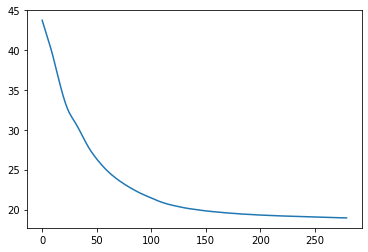

In [ ]:
plt.plot(plot_train_loss)

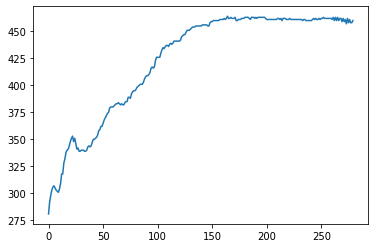

In [ ]:
plt.plot(plot_train_count)

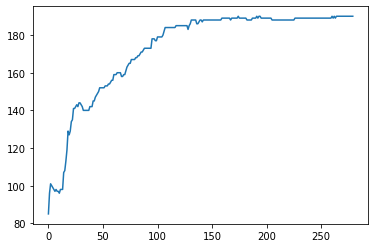

In [ ]:
plt.plot(plot_val_count)

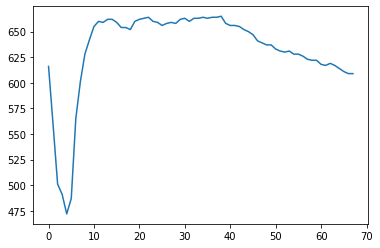

In [ ]:
plt.plot([(x) for x in plot_count4[:]])

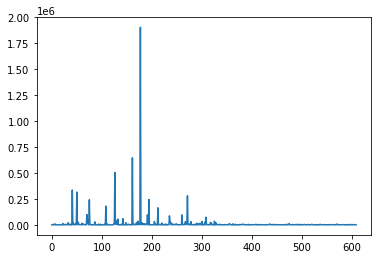

In [ ]:
plt.plot([(x) for x in plot_loss3[:]])

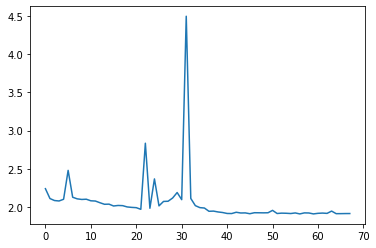

In [ ]:
plt.plot([np.log10(x) for x in (plot_loss4[:])])

[0.         0.         0.         0.         0.00185241 0.99695164
 1.         1.         1.         1.        ]
0.14059983455108516


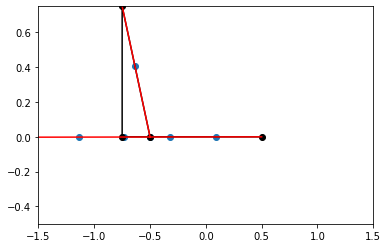

In [ ]:
#ind = indices[56]
ind=79

knots = np.array([0,0,0,0,rets[1][ind][4],rets[1][ind][5],1,1,1,1])
print(knots)

C = solve(inp[ind].numpy(), knots)
Ct = b_spline(C,knots,1000,True,3)
# plot_b_spline2(Ct,P[4*ind:4*ind+4],C,[-111,11],[-91,91])
plot_b_spline2(Ct,inp[ind].numpy(),C,[-1.5,1.5],[-0.5,0.75])
#print(arc(C, knots,3,1000))
print(global_curvature(C, knots,3,1000))

[0.         0.         0.         0.         0.30945983 0.61087486
 1.         1.         1.         1.        ]
64.83384604599092


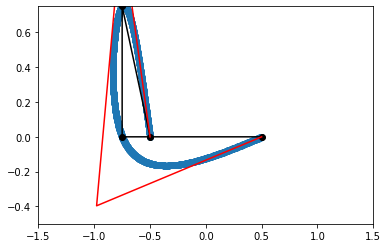

In [ ]:
knots = centripetal(inp[ind].numpy())
print(knots)

C1 = solve(inp[ind].numpy(), knots)
Ct = b_spline(C1,knots,1000,True,3)
plot_b_spline2(Ct,inp[ind].numpy(),C1,[-1.5,1.5],[-0.5,0.75])
print(global_curvature(C1, knots,3,1000))
#print(arc(C1, knots,3,1000))

In [ ]:
vtrainers.shape

torch.Size([198, 4])

In [ ]:
with torch.no_grad():
  #ret = net.forward((f.unsqueeze(0),inp.unsqueeze(0)))
  #ret = net.forward((trainer,inp))
  #ret,w = net.forward((feat,inp))
  #rets = net2.forward((trainers,inp))
  rets = net2.forward((testt,testc))

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.3399, 0.7777, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0150, 0.9700, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3307, 0.5812, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3461, 0.5781, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0077, 0.9953, 1.0000, 1.0000, 1.0000,
         1.0000]], dtype=torch.float64)


In [ ]:
testt.shape

torch.Size([1000, 4])

[0.         0.         0.         0.         0.36411619 0.64081943
 1.         1.         1.         1.        ]
103.18969480735404


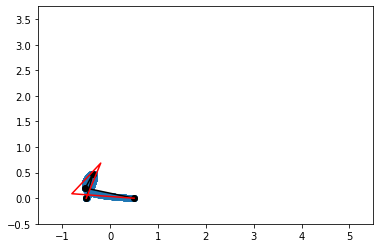

In [ ]:
ind = 316

knots = np.array([0,0,0,0,rets[1][ind][4],rets[1][ind][5],1,1,1,1])
print(knots)

C = solve(testc[ind].numpy(), knots)
Ct = b_spline(C,knots,1000,True,3)
# plot_b_spline2(Ct,P[4*ind:4*ind+4],C,[-111,11],[-91,91])
plot_b_spline2(Ct,testc[ind].numpy(),C,[-1.5,5.5],[-0.5,3.75])
# plot_b_spline2(Ct,testc[ind].numpy(),C,[-1.5,11.5],[-3.5,3.75])
#print(arc(C, knots,3,1000))
print(global_curvature(C, knots,3,1000))

[0.         0.         0.         0.         0.30804359 0.55640554
 1.         1.         1.         1.        ]
112.76910090478714


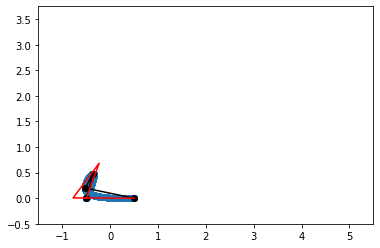

In [ ]:
knots = centripetal(testc[ind].numpy())
print(knots)

C1 = solve(testc[ind].numpy(), knots)
Ct = b_spline(C1,knots,1000,True,3)
plot_b_spline2(Ct,testc[ind].numpy(),C1,[-1.5,5.5],[-0.5,3.75])
print(global_curvature(C, knots,3,1000))
#print(arc(C1, knots,3,1000))

In [ ]:
rets=torch.load('rets.pt')
vrets=torch.load('vrets.pt')
trets=torch.load('trets.pt')

opt=torch.load('opt.pt')
optv=torch.load('optv.pt')
optt=torch.load('optt.pt')


In [ ]:
diff = np.abs(np.array(rets[0]) - np.array(opt))
print('mean diff',np.mean(diff))
print('std diff',np.std(diff))

mean diff 5.022594043428067
std diff 6.011566903018059


In [ ]:
diff = np.abs(np.array(trli) - np.array(opt))
print('mean diff',np.mean(diff))
print('std diff',np.std(diff))

mean diff 22.969879517546
std diff 23.353417602463264


In [ ]:
diff = np.abs(np.array(vrets[0]) - np.array(optv))
print('mean diff',np.mean(diff))
print('std diff',np.std(diff))

mean diff 16.06574013478129
std diff 17.231360124296977


In [ ]:
diff = np.abs(np.array(vli) - np.array(optv))
print('mean diff',np.mean(diff))
print('std diff',np.std(diff))

mean diff 83.37929419931903
std diff 52.425960543547646


In [ ]:
# torch.save(trli,'trli.pt')
# torch.save(vli,'vli.pt')
# torch.save(tli,'tli.pt')

In [ ]:
diff = np.abs(np.array(trets[0]) - np.array(optt))/np.array(optt)
print('mean diff',np.mean(diff))
print('std diff',np.std(diff))

mean diff 3060.715077521932
std diff 50377.276579042205


In [ ]:
diff = np.abs(np.array(tli) - np.array(optt))/np.array(optt)
print('mean diff',np.mean(diff))
print('std diff',np.std(diff))

mean diff 32914.23194467328
std diff 714795.1194897651


In [ ]:
k = [klist[i] for i in indices]
kv = [klist[i] for i in vindices]
kt = [klist[i] for i in tindices]

In [ ]:
optk = [knots_load[i] for i in indices]
optkv = [knots_load[i] for i in vindices]
optkt = [knots_load[i] for i in tindices]

array([[0.17312789, 0.1685257 ]])

In [ ]:
diff = np.abs(np.array(rets[1]) - np.array(optk))
print('mean diff',np.mean(np.expand_dims(diff[:,4:-4],0),1))
print('std diff',np.std(np.expand_dims(diff[:,4:-4],0),1))

mean diff [[0.09066688 0.09558177]]
std diff [[0.08992501 0.09419204]]


In [ ]:
diff = np.abs(np.array(k) - np.array(optk))
print('mean diff',np.mean(np.expand_dims(diff[:,4:-4],0),1))
print('std diff',np.std(np.expand_dims(diff[:,4:-4],0),1))

mean diff [[0.16304484 0.16411111]]
std diff [[0.10035978 0.09875365]]


In [ ]:
diff = np.abs(np.array(vrets[1]) - np.array(optkv))
print('mean diff',np.mean(np.expand_dims(diff[:,4:-4],0),1))
print('std diff',np.std(np.expand_dims(diff[:,4:-4],0),1))

mean diff [[0.07965315 0.07969434]]
std diff [[0.06619577 0.06991079]]


In [ ]:
diff = np.abs(np.array(kv) - np.array(optkv))
print('mean diff',np.mean(np.expand_dims(diff[:,4:-4],0),1))
print('std diff',np.std(np.expand_dims(diff[:,4:-4],0),1))

mean diff [[0.17944624 0.17808342]]
std diff [[0.09471333 0.09419116]]


In [ ]:
diff = np.abs(np.array(trets[1]) - np.array(optkt))
print('mean diff',np.mean(np.expand_dims(diff[:,4:-4],0),1))
print('std diff',np.std(np.expand_dims(diff[:,4:-4],0),1))

mean diff [[0.15917708 0.14448543]]
std diff [[0.11400965 0.10015763]]


In [ ]:
diff = np.abs(np.array(kt) - np.array(optkt))
print('mean diff',np.mean(np.expand_dims(diff[:,4:-4],0),1))
print('std diff',np.std(np.expand_dims(diff[:,4:-4],0),1))

mean diff [[0.20814505 0.20089195]]
std diff [[0.09913635 0.09560429]]
